In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/'
sys.path.append(path)
from field_grid import *
from format_field import get_field_df

In [3]:
#Point to the field data and get the df
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/data/'
file = "60Hr_Average_Comparison_all_3956_3997_norescut.txt"
# file = "60Hr_Average_Comparison_all_3956_3997_norescut_NoAvg.txt"
file = path + file
df_field = get_field_df(file)

In [4]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/muon_info'
sys.path.append(path)
from simple_ctags import get_ctags


In [5]:
data = get_ctags("2018-04-22 00:00:00", "2018-04-25 00:00:00",'localhost')
df_muons = pd.DataFrame.from_dict(data, orient="index",columns=['ctags'])
df_muons.index.name = 'DateTime'
df_muons.index = pd.to_datetime(df_muons.index)
df_muons = df_muons.sort_values(by=['DateTime'])

In [6]:
#Get the muons/ctag time interval (shorter than the field's time interval)
muons_time_interval = (df_muons.index.values[1].astype('int64')
                      - df_muons.index.values[0].astype('int64'))//1e9

#upsample each dataframe to 1 second                      
df_muons = df_muons.resample('1S').ffill()
df_field = df_field.resample('1S').ffill()

#Join the dataframes
df_total = df_field.join(df_muons)
df_total = df_total.fillna(0)

#calculate ctags per second and add it as a column
factor = 1/float(muons_time_interval)
df_total['ctags_per_second'] = df_total['ctags'].astype(float)*factor

In [7]:
total_ctags = df_total["ctags_per_second"].sum()
b = [
    (df_total["D"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["SQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NS"]*df_total["ctags_per_second"]).sum()/total_ctags
    ]
eb = [
    (df_total["eD"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["eNQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["eSQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["eNS"]*df_total["ctags_per_second"]).sum()/total_ctags
    ]

In [8]:
b[0]

841.4022102960945

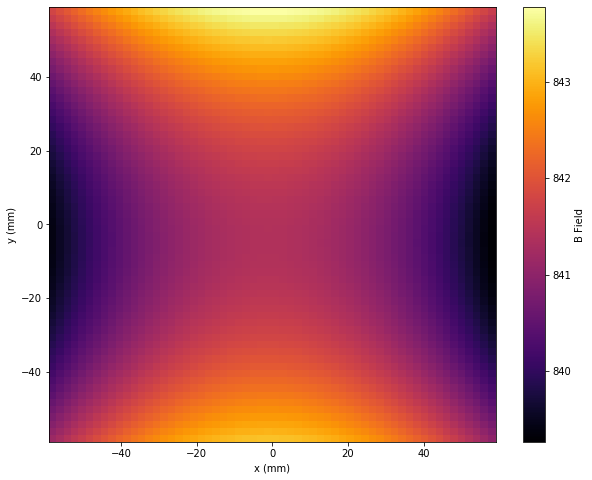

In [9]:
#First the field
df_field_grid = get_field_grid(b)
fig = plot_field(df_field_grid)
fig

In [10]:
#Next the error on the field
df_field_grid_error = get_field_grid(eb)
fig = plot_field(df_field_grid_error)
# fig

In [11]:
import sys
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/tracker_info'
sys.path.append(path)
from beam_moments import *
from transform_beam import *

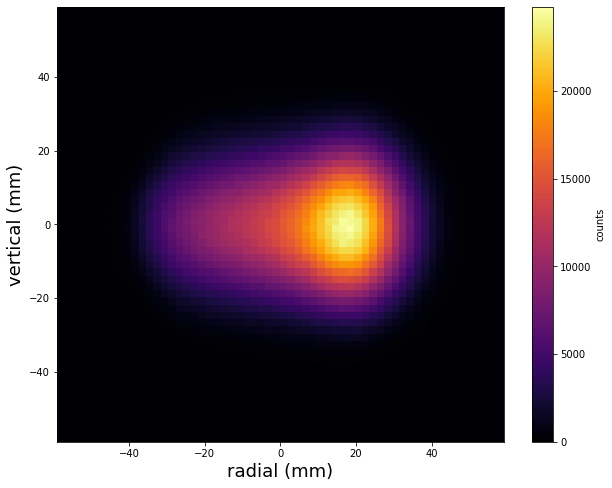

In [12]:
df_tracker = get_df_tracker()
#only look at station 12
df_tracker = df_tracker[df_tracker["Station"] == 'station12']
fig = plot_beam(df_tracker,bins=60)
fig

In [13]:
B = (df_tracker['counts']*df_field_grid['B']).sum()/(df_tracker['counts'].sum())
eB = (df_tracker['counts']*df_field_grid_error['B']).sum()/(df_tracker['counts'].sum())
print("Final Result = ",B,"+/-",eB)

Final Result =  841.2667976859057 +/- 0.1352164745573558


In [14]:
df_tracker.head()

,index,radial,vertical,counts,Station
0,2,-59.0,-59.0,0.0,station12
1,3,-59.0,-57.0,0.0,station12
2,4,-59.0,-55.0,0.0,station12
3,5,-59.0,-53.0,0.0,station12
4,6,-59.0,-51.0,0.0,station12


# Move the beam around to see the effect on the final muon-weighted average

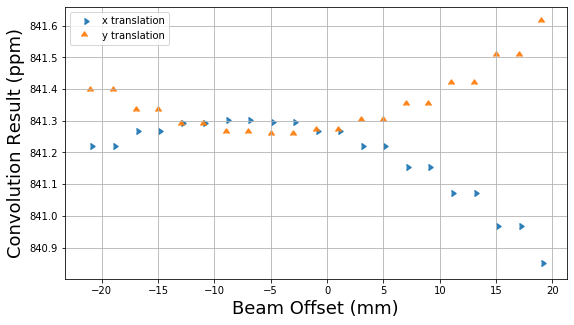

In [15]:
fig = plt.figure(figsize=(9,5))
B_arr = np.empty(0)
x_range = np.arange(-21,21,2.0)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_tracker,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=9,
            label="x translation")


B_arr = np.empty(0)
y_range = np.arange(-21,21,2.0)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_tracker,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker=10,
            label="y translation")


plt.xlabel("Beam Offset (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.legend()
plt.grid()
plt.show()

# Now we want to produce the same plot, but using a narrower/wider beam

Specifically, we want to subract the effect of detection off the beam. It has been shown in https://gm2-docdb.fnal.gov/cgi-bin/private/RetrieveFile?docid=18094&filename=2019_05_30_Tracker_Pitch.pdf&version=2
that the vertical and hoizantal resolution of the tracker is 3 mm, so this is what we want to subract.

In [16]:
df_narrow = df_tracker.copy()



df_narrow['counts']
w = df_narrow['counts']
v = df_narrow['vertical']
r = df_narrow['radial']
m_r = get_mean(r,w) #the radial mean
m_v = get_mean(v,w) #the vertical mean
rms_r = get_rms(r,m_r,w) #the radial rms
rms_v = get_rms(v,m_v,w) #the vertical rms


#first shift the beam
# df_narrow = shift_beam(df_narrow,-2.64,0)
#now narrow the beam
df_narrow = narrow(df_narrow,1.7,'counts','narrow')

w = df_narrow['narrow']
v = df_narrow['vertical']
r = df_narrow['radial']
m_r_new = get_mean(r,w) #the radial mean
m_v_new = get_mean(v,w) #the vertical mean
rms_r_new = get_rms(r,m_r_new,w) #the radial rms
rms_v_new = get_rms(v,m_v_new,w) #the vertical rms

print("original radial mean and rms:",m_r,rms_r)
print("original vertical mean and rms:",m_v,rms_v,'\n')

print("new radial mean and rms:",m_r_new,rms_r_new)
print("new vertical mean and rms:",m_v_new,rms_v_new,'\n')

print("radial change in mean and rms:",m_r_new - m_r,rms_r_new - rms_r)
print("vertical change in mean and rms:",m_v_new - m_v,rms_v_new - rms_v)


original radial mean and rms: 6.7936760480339125 18.256241636284077
original vertical mean and rms: -0.005800812143173988 12.805590974050983 

new radial mean and rms: 9.439720734489155 15.286170257105889
new vertical mean and rms: -0.14103951348483268 10.298741000142906 

radial change in mean and rms: 2.6460446864552427 -2.9700713791781883
vertical change in mean and rms: -0.1352387013416587 -2.5068499739080767


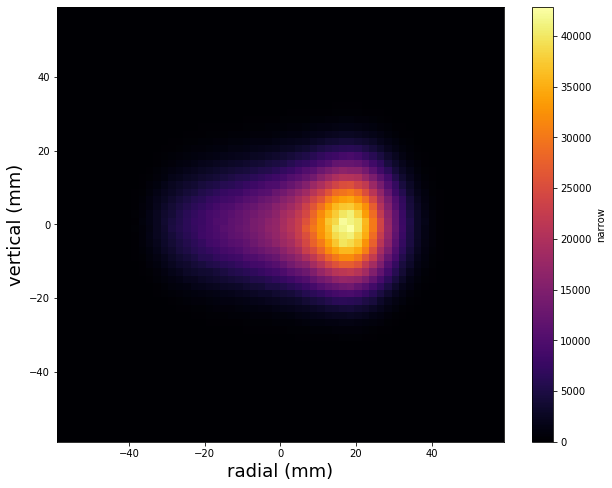

In [17]:
plot_beam(df_narrow,var='narrow')

In [18]:
mask = df_tracker['Station'] == 'station12'
df_conv = df_tracker[mask].copy()

c = convolve_df(df_conv,59,3)
df_conv['conv'] = c

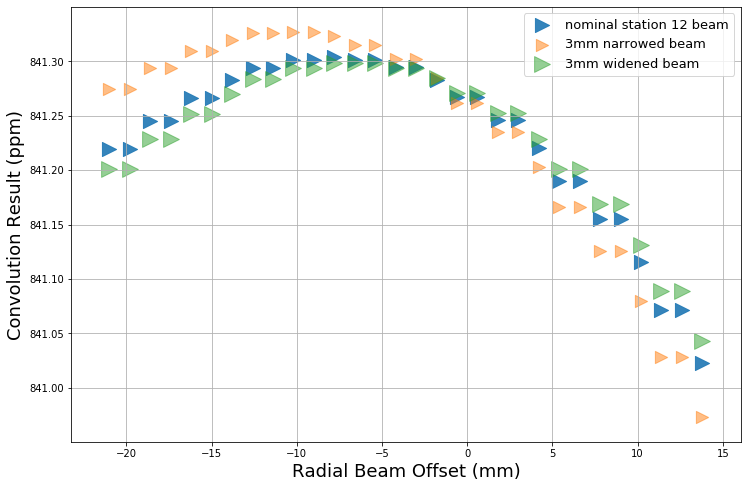

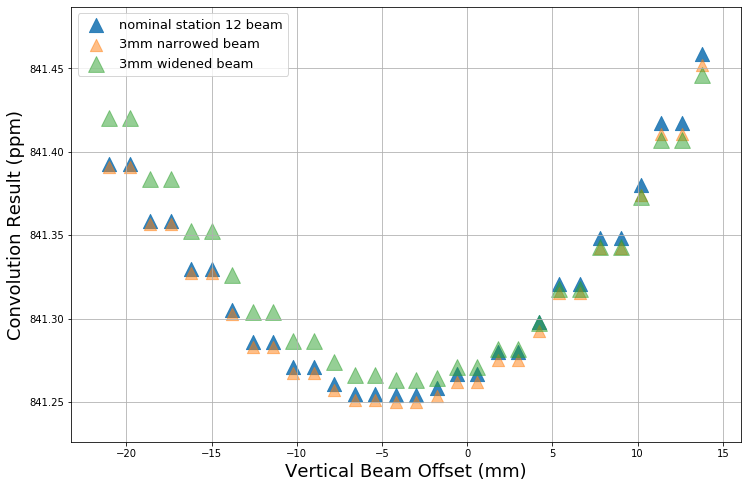

In [19]:
spacing = 1.2

fig = plt.figure(figsize=(12,8))
B_arr = np.empty(0)
x_range = np.arange(-21,14,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_tracker,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=">",s=200,
            label="nominal station 12 beam")






##narrowed beam


df_narrow['counts'] = df_narrow['narrow']
yshift = 0
x_range = np.arange(-21,14,spacing)
B_arr = np.empty(0)
for xshift in x_range:
    df = shift_beam(df_narrow,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.5, marker=">",s=150,
            label="3mm narrowed beam")



#widened beam
df_conv['counts'] = df_conv['conv']
yshift = 0
x_range = np.arange(-21,14,spacing)
B_arr = np.empty(0)
for xshift in x_range:
    df = shift_beam(df_conv,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.5, marker=">",s=250,
            label="3mm widened beam")


plt.xlabel("Radial Beam Offset (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.legend(prop={'size': 13})
plt.grid()
plt.show()








fig = plt.figure(figsize=(12,8))

B_arr = np.empty(0)
y_range = np.arange(-21,14,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_tracker,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker="^",s=200,
            label="nominal station 12 beam")



B_arr = np.empty(0)
y_range = np.arange(-21,14,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_narrow,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.5,marker="^",s=150,
            label="3mm narrowed beam")





B_arr = np.empty(0)
y_range = np.arange(-21,14,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_conv,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.5,marker="^",s=250,
            label="3mm widened beam")




plt.xlabel("Vertical Beam Offset (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.legend(prop={'size': 13})
plt.grid()
plt.show()





# Now look at a plot of convolution result vs broadening 

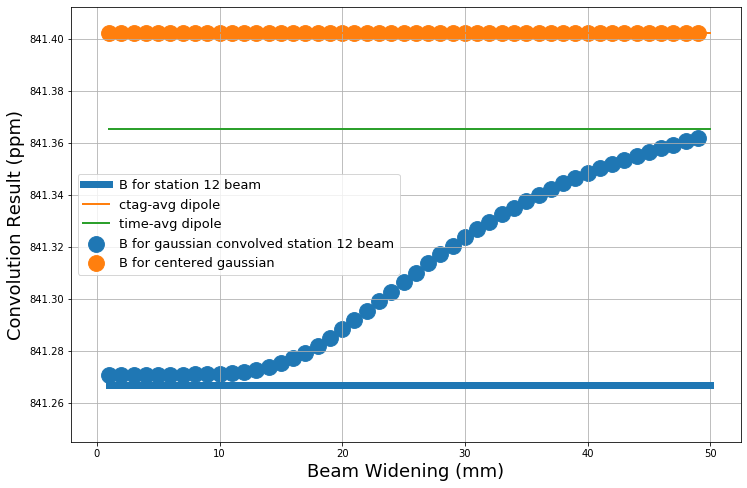

In [20]:
df_conv.reset_index(inplace=True)
fig = plt.figure(figsize=(12,8))
mask = df_tracker['Station'] == 'station12'
df_conv = df_tracker[mask].copy()

spacing = 1
high = 50

B_arr = np.empty(0)
sigmas = np.arange(spacing,high,spacing)
for sigma in sigmas:
    c = convolve_df(df_conv,59,sigma)
    df_conv['conv'] = c.astype(int)
    B = (df_conv['conv']*df_field_grid['B']).sum()/(df_conv['conv'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(sigmas, B_arr,marker="o",
            s=250,label='B for gaussian convolved station 12 beam')


#do the same with a centered gaussian beam
B_arr = np.empty(0)
sigmas = np.arange(spacing,high,spacing)
for sigma in sigmas:
    g = gaussian_kernel(59,sigma)
    g = np.reshape(g, (60*60),-1)
    df_conv['gaus'] = g
    B = (df_conv['gaus']*df_field_grid['B']).sum()/(df_conv['gaus'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(sigmas, B_arr,marker="o",
            s=250, label='B for centered gaussian')



#B for the regular beam
B = (df_conv['counts']*df_field_grid['B']).sum()/(df_conv['counts'].sum())
plt.plot([spacing, high], [B, B], 
         linestyle='-', linewidth=7,label='B for station 12 beam')

#Just the ctag weighted dipole
D = (df_total["D"]*df_total["ctags_per_second"]).sum()/df_total["ctags_per_second"].sum()
plt.plot([spacing, high], [D, D], 
         linestyle='-', linewidth=2,label='ctag-avg dipole')


#Just the time-weighted dipole
D = df_total["D"].mean()
plt.plot([spacing, high], [D, D], 
         linestyle='-', linewidth=2,label='time-avg dipole')


plt.xlabel("Beam Widening (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.grid()
plt.legend(prop={'size': 13})
plt.show()
    

# The B field is the same everywhere, so the weighting should not matter

In [21]:
df_conv.reset_index(inplace=True)
df_conv.head(8)

,level_0,index,radial,vertical,counts,Station,conv,gaus
0,0,2,-59.0,-59.0,0.0,station12,994,0.000102
1,1,3,-59.0,-57.0,0.0,station12,1002,0.000108
2,2,4,-59.0,-55.0,0.0,station12,1013,0.000113
3,3,5,-59.0,-53.0,0.0,station12,1029,0.000118
4,4,6,-59.0,-51.0,0.0,station12,1049,0.000123
5,5,7,-59.0,-49.0,16.0,station12,1072,0.000128
6,6,8,-59.0,-47.0,10.0,station12,1098,0.000134
7,7,9,-59.0,-45.0,2.0,station12,1127,0.000139


In [22]:
df_field_grid.head(8)

,x,y,B
0,-59.0,-59.0,841.153815
1,-59.0,-57.0,841.028336
2,-59.0,-55.0,840.907562
3,-59.0,-53.0,840.791493
4,-59.0,-51.0,840.680130
5,-59.0,-49.0,840.573471
6,-59.0,-47.0,840.471518
7,-59.0,-45.0,840.374270


In [23]:
df_conv['gaus'].var()

6.7648905911164016e-09

In [24]:
df_field_grid.iloc[0,2]

841.1538147333189

In [25]:
df_field_grid['B'].mean()

841.4022102960945

In [26]:
mask = (df_field_grid["B"] != df_field_grid.iloc[0,2])
df_field_grid[mask]

,x,y,B
1,-59.0,-57.0,841.028336
2,-59.0,-55.0,840.907562
3,-59.0,-53.0,840.791493
4,-59.0,-51.0,840.680130
5,-59.0,-49.0,840.573471
6,-59.0,-47.0,840.471518
7,-59.0,-45.0,840.374270
8,-59.0,-43.0,840.281726
9,-59.0,-41.0,840.193888
10,-59.0,-39.0,840.110755


In [27]:
a = (df_field_grid["B"]*df_conv["counts"]).sum()/df_conv["counts"].sum()
a

841.2667976859057

In [28]:
a = (df_field_grid["B"]*df_conv["conv"]).sum()/df_conv["conv"].sum()
a

841.3617702301458

In [29]:
a = (df_field_grid["B"]*df_conv["gaus"])
a = df_conv['gaus']
a = df_field_grid['B']
a

0       841.153815
1       841.028336
2       840.907562
3       840.791493
4       840.680130
           ...    
3595    841.089165
3596    841.222468
3597    841.360475
3598    841.503188
3599    841.650606
Name: B, Length: 3600, dtype: float64

In [30]:
df_field_grid['B'].mean()

841.4022102960945

In [31]:
(df_total["D"]*df_total["ctags_per_second"]).sum()/total_ctags

841.4022102960945

In [32]:
df_total["D"].mean()

841.3653730688554

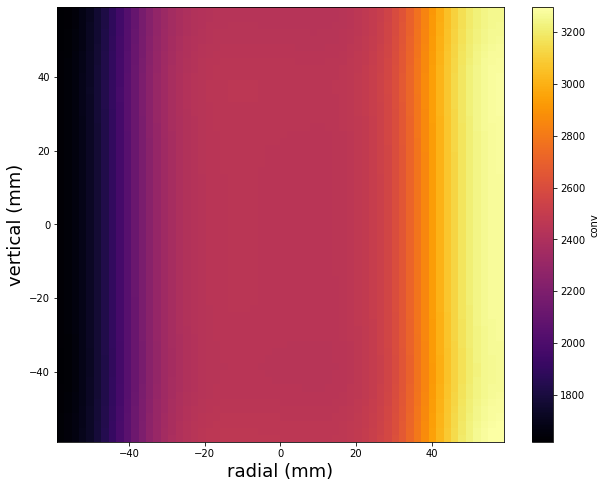

In [33]:
c = convolve_df(df_conv,59,1000000)
df_conv['conv'] = c
plot_beam(df_conv,var='conv')

In [34]:
mask = df_tracker['Station'] == 'station12'
df_test = df_tracker[mask].copy()
df_test.head()

,index,radial,vertical,counts,Station
0,2,-59.0,-59.0,0.0,station12
1,3,-59.0,-57.0,0.0,station12
2,4,-59.0,-55.0,0.0,station12
3,5,-59.0,-53.0,0.0,station12
4,6,-59.0,-51.0,0.0,station12


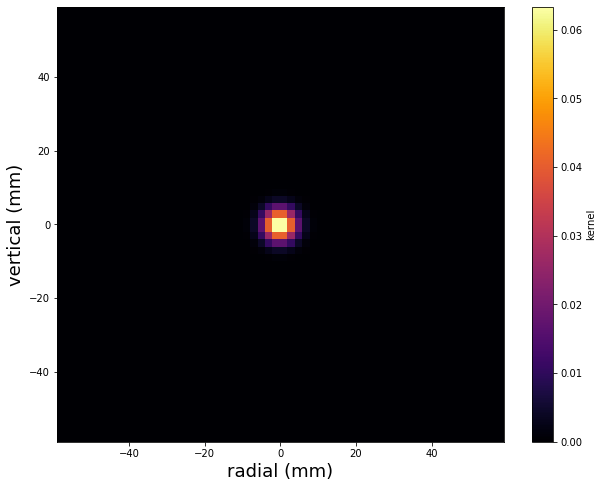

In [35]:
g = gaussian_kernel(59,3)
g = np.reshape(g, (60*60),-1)
# g
df_test['kernel'] = g
plot_beam(df_test,var='kernel')

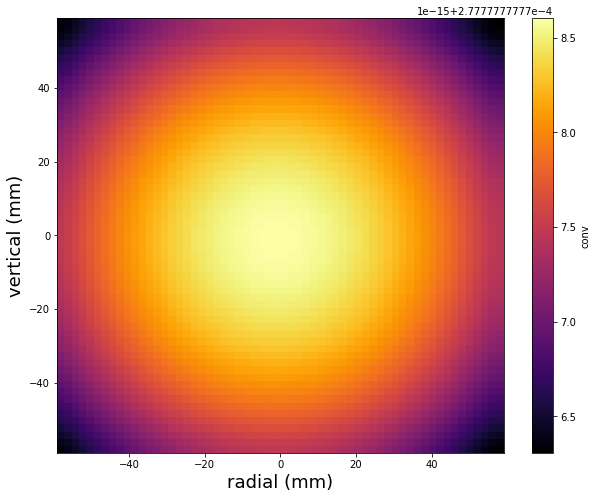

In [36]:
c = convolve_df(df_test,59,20000000,var='kernel')
df_test['conv'] = c
plot_beam(df_test,var='conv')